# Capstone Project - The Battle of Neighborhoods
## Introduction
Let's pick up the idea from the assignment description about the restaurant.

New York is one of the most popular major cities. Every year millions of people are visiting New York. And last year I was one of them ;-). Not only the citicens have to do one thing. Even the tourists have to do it ... eating.

Throughout the history of New York, it has been a hotspot for immigrants. This is why there is such a broad spectrum of the cuisine. You can get nearly everything from French, Indian over Chinese food. As Austrian I like the hearty cuisine as well as the sweet cuisine.

In this project I will focus on the restaurants which are selling desserts (i.e. Dessert Shop). I will analyse and visualise the parts of New York where the best Dessert Shops are.

This project could be the base for future projects. With some additional datasets it might be possible to do furhter analysis like:
  * where is the best place to open a new restaurant
  * will there be a hard competitor in this area
  * are there enough restaurants in that area

But now let us focus on this project.

## Data
To achive the goal of this project the following data is required:
  * geographical data from New York
    * Borough
    * Neighborhoods
    * coordinates (longitude, latitude)
  * restaurant information
    * classification
    * name
    * address
    * likes and rating

## Approach
  * collect data about New York City
  * collect data about all restaurants
  * filter the collected data to focus on a category
  * extend filtered data with ratings and likes
  * rank the restaurants
  * visualize the locations

## Questions
  * What is the best place to get desserts?
  * Which areas have the potential to evolve the market of sweets?
  * Which areas have a lack of Dessert Shops?

## Analysis
For the analysis there are some requirements:
  * using pandas and numpy libraries
  * using Foursquare API
  * using folium


# Coding

In [1]:
# importing some libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
import json
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [3]:
# in doubt install this libraries
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## Prepare data from NewYorkCity (PostalCode, Borough, Neighborhood, Latitude, Longitude)

In [4]:
# get data from url
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

# process json file
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# prepare table columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_ny_comp = pd.DataFrame(columns=column_names)
df_ny_comp
for data in neighborhoods_data:
    borough = hood_name = data['properties']['borough'] 
    hood_name = data['properties']['name']
        
    hood_latlon = data['geometry']['coordinates']
    hood_lat = hood_latlon[1]
    hood_lon = hood_latlon[0]
    
    df_ny_comp = df_ny_comp.append({'Borough': borough,
                                    'Neighborhood': hood_name,
                                    'Latitude': hood_lat,
                                    'Longitude': hood_lon}, ignore_index=True)
# check result
df_ny_comp.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
df_ny_comp.shape

(306, 4)

Dataframe looks good. Contains borough, neighborhood and coordinates for 306 different neighborhoods found.

In [6]:
# get coordinates from New York City, New York for a map
address_ny = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location_ny = geolocator.geocode(address_ny)
latitude_ny = location_ny.latitude
longitude_ny = location_ny.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ny_comp['Latitude'], df_ny_comp['Longitude'], df_ny_comp['Borough'], df_ny_comp['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Visualized the neighborhoods on the map. But which borough has the most neighborhoods?

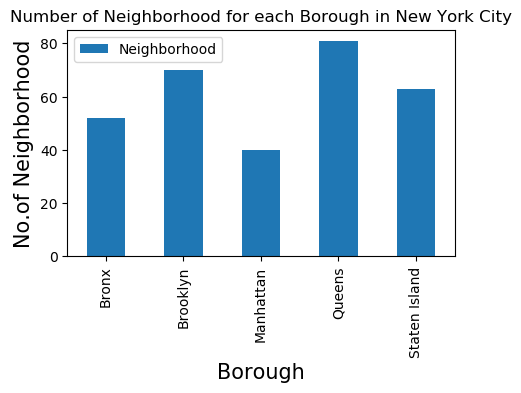

In [7]:
plt.figure(figsize=(5,3), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
df_ny_comp.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

Queen has most neighborhoods of all boroughs. Manhatten at least. 

## Time to get data from Foursquare

### Foursquare credentials

In [8]:
# @hidden_cell
CLIENT_ID = 'IP'
CLIENT_SECRET = 'IP'
VERSION = '20180605'

### Function to get venues

The following function interacts with Foursquare to get the ID and the names of venues of a specific type.

In [9]:
def get_venues(lat,lng):
    #set search variables
    radius=1000
    LIMIT=10
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data = results["response"]['groups'][0]['items']
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names = ['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
# prepare neighborhood list that contains Dessert Shops
column_names = ['Borough', 'Neighborhood', 'ID','Name']
ny_dessert = pd.DataFrame(columns=column_names)
count = 1
for row in df_ny_comp.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    dessert_shop = venues[venues['Category']=='Dessert Shop']   
    print('(',count,'/',len(df_ny_comp),')','Dessert Shop in '+Neighborhood+', '+Borough+':'+str(len(dessert_shop)))
    for restaurant_detail in dessert_shop.values.tolist():
        id, name , category=restaurant_detail
        ny_dessert = ny_dessert.append({'Borough': Borough,
                                        'Neighborhood': Neighborhood, 
                                        'ID': id,
                                        'Name' : name
                                       }, ignore_index=True)
    count+=1

( 1 / 306 ) Dessert Shop in Wakefield, Bronx:1
( 2 / 306 ) Dessert Shop in Co-op City, Bronx:0
( 3 / 306 ) Dessert Shop in Eastchester, Bronx:0
( 4 / 306 ) Dessert Shop in Fieldston, Bronx:0
( 5 / 306 ) Dessert Shop in Riverdale, Bronx:1
( 6 / 306 ) Dessert Shop in Kingsbridge, Bronx:0
( 7 / 306 ) Dessert Shop in Marble Hill, Manhattan:0
( 8 / 306 ) Dessert Shop in Woodlawn, Bronx:0
( 9 / 306 ) Dessert Shop in Norwood, Bronx:0
( 10 / 306 ) Dessert Shop in Williamsbridge, Bronx:0
( 11 / 306 ) Dessert Shop in Baychester, Bronx:0
( 12 / 306 ) Dessert Shop in Pelham Parkway, Bronx:1
( 13 / 306 ) Dessert Shop in City Island, Bronx:0
( 14 / 306 ) Dessert Shop in Bedford Park, Bronx:0
( 15 / 306 ) Dessert Shop in University Heights, Bronx:0
( 16 / 306 ) Dessert Shop in Morris Heights, Bronx:0
( 17 / 306 ) Dessert Shop in Fordham, Bronx:0
( 18 / 306 ) Dessert Shop in East Tremont, Bronx:0
( 19 / 306 ) Dessert Shop in West Farms, Bronx:0
( 20 / 306 ) Dessert Shop in High  Bridge, Bronx:0
( 21 /

In [11]:
ny_dessert

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4c537892fd2ea593cb077a28,Lollipops Gelato
1,Bronx,Riverdale,51cc87aa498e0e8caff2fe59,Menchie's
2,Bronx,Pelham Parkway,4c76e7da947ca1cd26c14537,Sal & Doms Bakery
3,Bronx,Belmont,4ae351a0f964a5205b9321e3,DeLillo Pastry Shop
4,Bronx,Spuyten Duyvil,51cc87aa498e0e8caff2fe59,Menchie's
5,Bronx,Olinville,4c76e7da947ca1cd26c14537,Sal & Doms Bakery
6,Brooklyn,Brighton Beach,4f25c695e4b067a3282c6735,Güllüoğlu Baklava & Cafe
7,Brooklyn,Park Slope,59da8dbd625a664540e7004d,Chocolateria
8,Manhattan,Soho,45e98bacf964a52080431fe3,MarieBelle
9,Queens,Maspeth,4de3d09f1f6e3190cd303468,Isabella's Ices


In [12]:
ny_dessert.shape

(22, 4)

There are 22 Dessert Shops in NYC. Not so much it thought.

Lets have a look on the distribution of the Dessert Shops to the boroughs. 

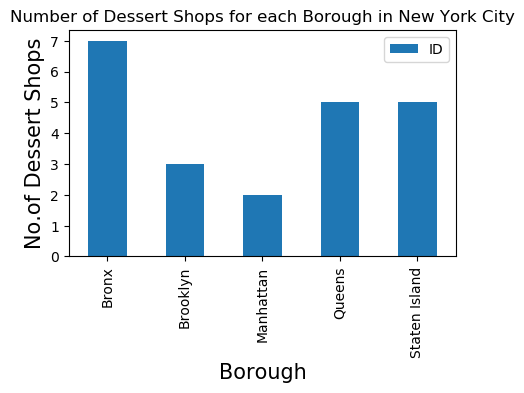

In [14]:
plt.figure(figsize=(5,3), dpi = 100)
plt.title('Number of Dessert Shops for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Dessert Shops', fontsize=15)
ny_dessert.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

Most of them are in the Bronx. Once again Manhattan is on the last place.

What about the distribution in each neighborhood?

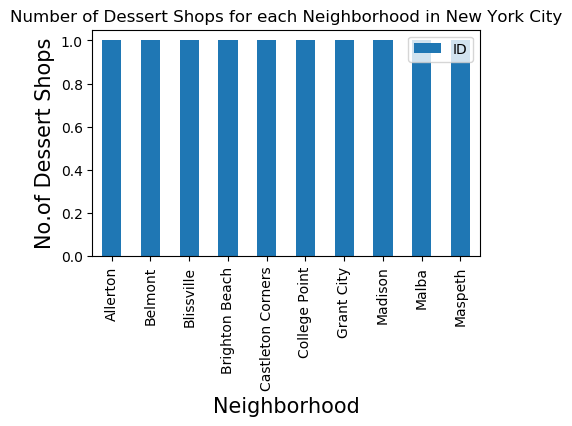

In [15]:
plt.figure(figsize=(5,3), dpi = 100)
plt.title('Number of Dessert Shops for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Dessert Shops', fontsize=15)
ny_dessert.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
plt.legend()
plt.show()

In every neighborhood there is only one Dessert Shop.

### Function to retrieve detailed data from Foursquare

The following function interacts with Foursquare to get the likes, ratings and tips of a venue.

In [16]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Get the ranking of every restaurant.

In [17]:
# prepare neighborhood list that contains Dessert Shops
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
dessert_shop_stats_ny = pd.DataFrame(columns=column_names)
count=1


for row in ny_dessert.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ny_dessert),')','processed')
    dessert_shop_stats_ny = dessert_shop_stats_ny.append({'Borough': Borough,
                                                          'Neighborhood': Neighborhood, 
                                                          'ID': id,
                                                          'Name' : name,
                                                          'Likes' : likes,
                                                          'Rating' : rating,
                                                          'Tips' : tips
                                                         }, ignore_index=True)
    count+=1

                         ID              Name  Likes  Rating  Tips
0  4c537892fd2ea593cb077a28  Lollipops Gelato     18     8.5     4
( 1 / 22 ) processed
                         ID       Name  Likes  Rating  Tips
0  51cc87aa498e0e8caff2fe59  Menchie's     54     8.7    16
( 2 / 22 ) processed
                         ID               Name  Likes  Rating  Tips
0  4c76e7da947ca1cd26c14537  Sal & Doms Bakery     32     8.7    11
( 3 / 22 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4ae351a0f964a5205b9321e3  DeLillo Pastry Shop     84     8.4    28
( 4 / 22 ) processed
                         ID       Name  Likes  Rating  Tips
0  51cc87aa498e0e8caff2fe59  Menchie's     54     8.7    16
( 5 / 22 ) processed
                         ID               Name  Likes  Rating  Tips
0  4c76e7da947ca1cd26c14537  Sal & Doms Bakery     32     8.7    11
( 6 / 22 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4f25c695e4

In [18]:
dessert_shop_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4c537892fd2ea593cb077a28,Lollipops Gelato,18,8.5,4
1,Bronx,Riverdale,51cc87aa498e0e8caff2fe59,Menchie's,54,8.7,16
2,Bronx,Pelham Parkway,4c76e7da947ca1cd26c14537,Sal & Doms Bakery,32,8.7,11
3,Bronx,Belmont,4ae351a0f964a5205b9321e3,DeLillo Pastry Shop,84,8.4,28
4,Bronx,Spuyten Duyvil,51cc87aa498e0e8caff2fe59,Menchie's,54,8.7,16
5,Bronx,Olinville,4c76e7da947ca1cd26c14537,Sal & Doms Bakery,32,8.7,11
6,Brooklyn,Brighton Beach,4f25c695e4b067a3282c6735,Güllüoğlu Baklava & Cafe,46,7.7,11
7,Brooklyn,Park Slope,59da8dbd625a664540e7004d,Chocolateria,13,8.7,3
8,Manhattan,Soho,45e98bacf964a52080431fe3,MarieBelle,209,9.1,95
9,Queens,Maspeth,4de3d09f1f6e3190cd303468,Isabella's Ices,6,8.0,2


In [19]:
dessert_shop_stats_ny.shape

(22, 7)

Just checked if there are still 22 dataframes. => still ok.

Check the retrieved data.

In [20]:
dessert_shop_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
Borough         22 non-null object
Neighborhood    22 non-null object
ID              22 non-null object
Name            22 non-null object
Likes           22 non-null object
Rating          22 non-null float64
Tips            22 non-null object
dtypes: float64(1), object(6)
memory usage: 1.3+ KB


Not every value has the right value for further processing. Likes and Tips are from type object but should be float. So convert them.

In [21]:
dessert_shop_stats_ny['Likes']=dessert_shop_stats_ny['Likes'].astype('float64')

In [22]:
dessert_shop_stats_ny['Tips']=dessert_shop_stats_ny['Tips'].astype('float64')

In [23]:
dessert_shop_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
Borough         22 non-null object
Neighborhood    22 non-null object
ID              22 non-null object
Name            22 non-null object
Likes           22 non-null float64
Rating          22 non-null float64
Tips            22 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.3+ KB


Much better ;-)

### Find the best results

In [24]:
# Restaurant with maximum Likes
dessert_shop_stats_ny.iloc[dessert_shop_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              45e98bacf964a52080431fe3
Name                          MarieBelle
Likes                                209
Rating                               9.1
Tips                                  95
Name: 8, dtype: object

In [25]:
# Restaurant with maximum Rating
dessert_shop_stats_ny.iloc[dessert_shop_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              45e98bacf964a52080431fe3
Name                          MarieBelle
Likes                                209
Rating                               9.1
Tips                                  95
Name: 8, dtype: object

In [26]:
# Restaurant with maximum Tips
dessert_shop_stats_ny.iloc[dessert_shop_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              45e98bacf964a52080431fe3
Name                          MarieBelle
Likes                                209
Rating                               9.1
Tips                                  95
Name: 8, dtype: object

Looks like we have a winner. This one has best marks in all three categories.

### Average values per neighborhood

In [27]:
ny_neighborhood_stats=dessert_shop_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [28]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
17,Soho,9.1
21,Westerleigh,8.9
15,Port Richmond,8.9
6,Grant City,8.9
12,Olinville,8.7
18,Spuyten Duyvil,8.7
16,Riverdale,8.7
14,Pelham Parkway,8.7
13,Park Slope,8.7
0,Allerton,8.7


### Average values per borough

In [29]:
ny_borough_stats=dessert_shop_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [30]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,8.850000
0,Bronx,8.628571
4,Staten Island,8.600000
3,Queens,8.220000
1,Brooklyn,8.200000


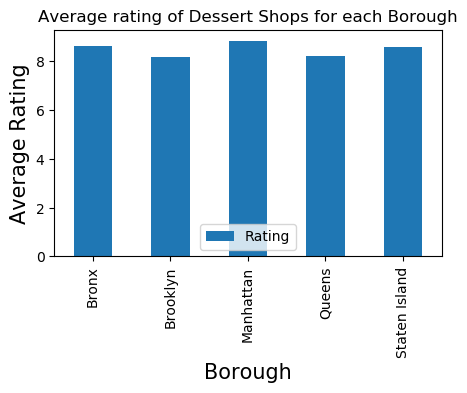

In [31]:
plt.figure(figsize=(5,3), dpi = 100)
plt.title('Average rating of Dessert Shops for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
dessert_shop_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

An average rating greater than 8.8 is a very good rating (IMHO). So just consider this neighborhoods.

In [32]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.8]

In [33]:
ny_neighborhood_stats

,Neighborhood,Average Rating
6,Grant City,8.9
15,Port Richmond,8.9
17,Soho,9.1
21,Westerleigh,8.9


Merge the average rating together with the original dataframe.

In [34]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_ny_comp, on='Neighborhood')

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [36]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Staten Island,Grant City,40.576216,-74.105856,8.9
1,Staten Island,Port Richmond,40.633669,-74.129434,8.9
2,Manhattan,Soho,40.722184,-74.000657,9.1
3,Staten Island,Westerleigh,40.621090,-74.133041,8.9


Visualize the results on a map.

In [37]:
# get coordinates from New York City, New York for a map
address_ny = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location_ny = geolocator.geocode(address_ny)
latitude_ny = location_ny.latitude
longitude_ny = location_ny.longitude

# create map of New York using latitude and longitude values
ny_map = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# add markers to map
for lat, lng in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )    


Add some labels

In [38]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [39]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [40]:
ny_borough_stats

,Borough,Average Rating
0,Bronx,8.628571
1,Brooklyn,8.200000
2,Manhattan,8.850000
3,Queens,8.220000
4,Staten Island,8.600000


# Conclusion

The best neighborhood for Dessert Shops is Soho followed by Westerleigh, Port Richmond and Grant City each equal.
Manhattan has the potential for Dessert Shops.
Brooklyn has the worst average rating for Dessert Shops.
The Bronx is the best place to stay for dining in a Dessert Shops.

# Limitations

The only source for data to rate the venues comes from Foursquare. Normally it should be considered to analyse different data sources.